In [10]:
import pickle
import gzip
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from PIL import Image
import os
import numpy as np
np.random.seed(666)

In [2]:
filename = '../mnist.pkl.gz'
f = gzip.open(filename, 'rb')
training_data, validation_data, test_data = pickle.load(f, encoding='latin1')
f.close()

In [3]:
# Functions
def one_hot_vect(tuple_data,classes):
    one_hot_encoded=np.zeros((len(tuple_data[1]),len(classes)))
    identity = np.identity(len(classes))
    for i in range(len(tuple_data[1])):
        one_hot_encoded[i] = np.add(one_hot_encoded[i],identity[tuple_data[1][i]])
    return one_hot_encoded

def softmax(weights,train_data):
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    num = np.dot(weights,train_withBias.T)
    # High value Fix
    # https://houxianxu.github.io/2015/04/23/logistic-softmax-regression/
    num = np.subtract(num,np.max(num,axis=0))
    num = np.exp(num)
    # Fix softmax when using batch size 1 the dimension of deno changes
    if(len(train_data) == 1):
        deno = np.sum(num,axis=0)
    else:
        deno = np.sum(num,axis=1)
        deno = deno.reshape((10,1))
    return np.divide(num,deno)

def cross_entropy_error(predicted,target):
    right = np.log(predicted+ 1/10**30)
    loss = np.multiply(np.matrix(target),np.transpose(np.matrix(right)))
    return -np.sum(np.sum(loss,axis=1),axis=0)

def batch_gradient(predicted,train_data,target):
    leftleft = np.transpose(predicted)
    left = np.subtract(leftleft,target)
    bias = np.ones((np.shape(train_data)[0],1))
    train_withBias = np.hstack((train_data,bias))
    gradient = np.dot(left.T,train_withBias)
    gradient = gradient/len(train_data)
    return np.matrix(gradient,dtype="float64")

def accuracy(predicted,target):
    correct = 0
    left = np.array(np.argmax(predicted,axis=0)).flatten()
    right = np.argmax(target,axis=1)
    confusion_mat = np.zeros((len(np.unique(right)),len(np.unique(left))))
    for i in range(len(target)):
        if(left[i] == right[i]):
            correct+=1
        confusion_mat[left[i]][right[i]] =confusion_mat[left[i]][right[i]] +1
    return correct/len(target),pd.DataFrame(np.matrix(confusion_mat,dtype="int32"))

def more_metrics(conf_mat):
    true_positives = 0
    precision = []
    recall = []
    for i in range(len(conf_mat)):
        true_positives += conf_mat.iloc[i,i]
    conf_mat = np.matrix(conf_mat)
    tp_fp = np.array(np.sum(conf_mat,axis=1)).ravel()
    relevant_elements = np.array(np.sum(conf_mat,axis=0)).ravel()
    for i in range(len(conf_mat)):
        precision.append(conf_mat[i,i]/tp_fp[i])
        recall.append(conf_mat[i,i]/relevant_elements[i])
    return true_positives,precision,recall

def epoch_shuffle(processed_train_data,target):
    # Merge
    trainDF = pd.DataFrame(processed_train_data)
    targetDF = pd.DataFrame(target)
    result = pd.concat([trainDF.reset_index(),targetDF.reset_index()],join='inner',axis=1)
    result = result.sample(frac=1)
    
    return np.asarray(result.iloc[:,1:np.shape(trainDF)[1]+1]),np.asarray(result.iloc[:,np.shape(trainDF)[1]+2:])

In [4]:
# Fixed Var
classes = np.unique(training_data[1])
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
train_data = training_data[0]

In [5]:
target = one_hot_vect(training_data,classes)
target_val = one_hot_vect(validation_data,classes)
target_test = one_hot_vect(test_data,classes)
scaler = StandardScaler()
scaler.fit(train_data)
processed_train_data = scaler.transform(train_data)
scaler.fit(validation_data[0])
processed_val_data = scaler.transform(validation_data[0])
scaler.fit(test_data[0])
processed_test_data = scaler.transform(test_data[0])

In [6]:
i = 0
batchSize = 1
start = 0
end = batchSize
batches = len(processed_train_data)/batchSize
weights = np.random.randn(len(classes), np.shape(training_data[0])[1]+1) * 0.001
predicted = softmax(weights,processed_train_data[start:end,:])
cost_initial = np.asscalar(cross_entropy_error(softmax(weights,processed_train_data),target))
cost_new = cost_initial*0.1
train_acc = 0
log_training_loss =[]
log_val_loss=[]
log_training_acc =[]
log_val_acc=[]
logging=True
while(cost_initial-cost_new > 10):
    i = 0
    start = 0
    end = batchSize
    while(i<batches-1):
        #print("Percentage Done: "+str(i/batches))
        new_weights = batch_gradient(predicted,processed_train_data[start:end,:],target[start:end,:])
        weights = weights - 0.0003*new_weights
        if(logging and i%2500==0):
            # Predict Train & Validation for these weights
            predict_val = softmax(weights,processed_val_data)
            # Calculate cost of predicting Validation and Training, To see if the hyper param are working
            acc,_  = accuracy(predict_val,target_val)
            log_val_acc.append(acc)
            log_val_loss.append(np.asscalar(cross_entropy_error(predict_val,target_val)))
            predict_train = softmax(weights,processed_train_data)
            acc,_  = accuracy(predict_train,target)
            log_training_acc.append(acc)
            log_training_loss.append(np.asscalar(cross_entropy_error(predict_train,target)))
        #print("Training Loss: "+str(cost))
        start = start + batchSize
        end = end + batchSize
        # New Prediction for the data
        predicted = softmax(weights,processed_train_data[start:end,:])
        i = i+1
    cost_initital = cost_new
    pred_train = softmax(weights,processed_train_data)
    cost_new = np.asscalar(cross_entropy_error(pred_train,target))
    predict_val = softmax(weights,processed_val_data)
    val_acc,_ = accuracy(predict_val,target_val)
    train_acc_old = train_acc
    train_acc,_ = accuracy(pred_train,target)
    if(float(train_acc) - float(train_acc_old) < 0.000001 ):
        # Early stopping where just cost is changing but accuracy is stuck
        break
    print("Cost after Epoch: "+str(cost_new))
    print("Val Acc: "+str(val_acc))
    print("Train Acc: "+str(train_acc))
    processed_train_data,target = epoch_shuffle(processed_train_data,target)

Cost after Epoch: 444485.60814204026
Val Acc: 0.9133
Train Acc: 0.90652
Cost after Epoch: 442570.4953225428
Val Acc: 0.9199
Train Acc: 0.91648
Cost after Epoch: 441727.63461500575
Val Acc: 0.9221
Train Acc: 0.91986
Cost after Epoch: 441178.8726085518
Val Acc: 0.9242
Train Acc: 0.9225
Cost after Epoch: 440891.2580628709
Val Acc: 0.9255
Train Acc: 0.92362
Cost after Epoch: 440567.9224676473
Val Acc: 0.9258
Train Acc: 0.92606
Cost after Epoch: 440361.4678738564
Val Acc: 0.9259
Train Acc: 0.92696
Cost after Epoch: 440192.3217455582
Val Acc: 0.9274
Train Acc: 0.92796
Cost after Epoch: 440029.4262212026
Val Acc: 0.9261
Train Acc: 0.92856
Cost after Epoch: 439932.53451414785
Val Acc: 0.9261
Train Acc: 0.92896
Cost after Epoch: 439798.71011547773
Val Acc: 0.9271
Train Acc: 0.92992
Cost after Epoch: 439742.17929687235
Val Acc: 0.927
Train Acc: 0.9301
Cost after Epoch: 439612.34039090533
Val Acc: 0.9272
Train Acc: 0.93076
Cost after Epoch: 439559.9850890138
Val Acc: 0.927
Train Acc: 0.93112
Cost

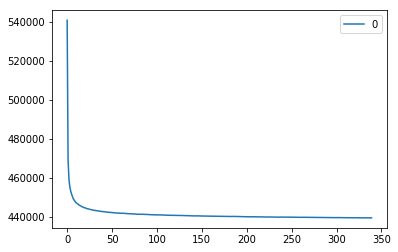

In [7]:
df = pd.DataFrame(log_training_loss)
ax = df.plot()
ax.ticklabel_format(useOffset=False)
plt.savefig('./train_loss.png',bbox_inches='tight')
plt.show(ax)

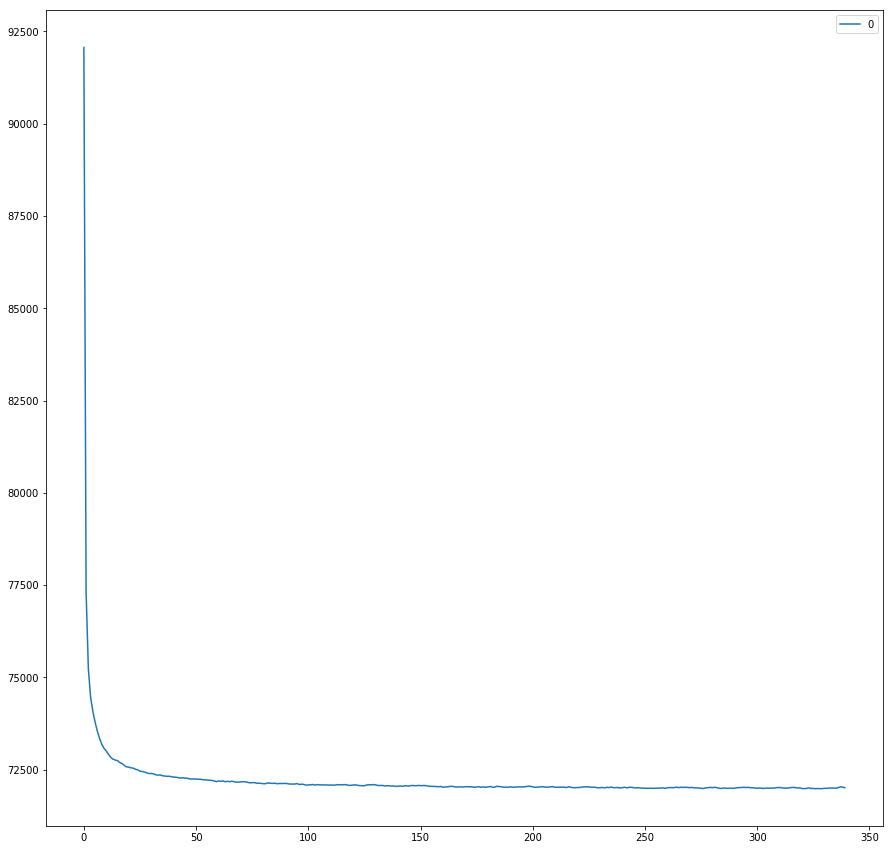

In [9]:
df = pd.DataFrame(log_val_loss)
ax = df.plot(figsize=(15,15))
ax.ticklabel_format(useOffset=False)
plt.savefig('./val_loss.png',bbox_inches='tight')
plt.show(ax)

In [12]:
predict_val = softmax(weights,processed_val_data)
acc,conf_mat = accuracy(predict_val,target_val)
print("The Accuracy for Validation is: "+str(acc))
print("The Confusion Matrix is: ")
print(pd.DataFrame(conf_mat))
_,precision,recall = more_metrics(pd.DataFrame(conf_mat))
print("The Precision & Recall is: ")
df = pd.DataFrame(np.multiply(precision,100))
df.columns = ["Precision"]
df1 = pd.DataFrame(np.multiply(recall,100))
df1.columns = ["Recall"]
print(pd.concat([df,df1],axis=1))

The Accuracy for Validation is: 0.9278
The Confusion Matrix is: 
     0     1    2    3    4    5    6     7    8    9
0  964     0    3    5    1   11    4     5    4    4
1    0  1044   12    3   10    2    4     5   31    5
2    6     4  896   13    3   13    7     5    6    2
3    1     2   15  920    2   32    0     8   19    8
4    4     1   11    1  929    7    6     5    2   27
5    4     4    6   44    0  797    7     0   24    7
6    6     0    6    3    6   23  936     0    4    1
7    3     1   15    5    5    6    1  1033    8   32
8    3     7   22   26    2   20    2     1  889    5
9    0     1    4   10   25    4    0    28   22  870
The Precision & Recall is: 
   Precision     Recall
0  96.303696  97.275479
1  93.548387  98.120301
2  93.821990  90.505051
3  91.360477  89.320388
4  93.554884  94.506612
5  89.249720  87.103825
6  95.025381  96.794209
7  93.146979  94.770642
8  90.992835  88.107037
9  90.248963  90.530697


In [14]:
np.savetxt('./models/logisticModel', weights)

# USPS Data Test

In [16]:
USPSMat  = []
USPSTar  = []
curPath  = '../USPSdata/Numerals'
savedImg = []

for j in range(0,10):
    curFolderPath = curPath + '/' + str(j)
    imgs =  os.listdir(curFolderPath)
    for img in imgs:
        curImg = curFolderPath + '/' + img
        if curImg[-3:] == 'png':
            img = Image.open(curImg,'r')
            img = img.resize((28, 28))
            savedImg = img
            imgdata = (255-np.array(img.getdata()))/255
            USPSMat.append(imgdata)
            USPSTar.append(j)

In [17]:
target_USPS = one_hot_vect((1,USPSTar),classes)
scaler.fit(USPSMat)
processed_USPSDat = scaler.transform(USPSMat)


In [18]:
predict_USPS = softmax(weights,processed_USPSDat)
accuracy(predict_USPS,target_USPS)

(0.3336666833341667,      0    1     2    3    4    5    6    7    8    9
 0  526   55    81   75   35  143   85  137  233   36
 1   20  324    77   77   98   71   18  205   70  138
 2  152  224  1125  161   33  193  382   43   64   58
 3   66  246   100  888   27  134   77  381  269  413
 4  134  321    32   18  949   38   60   59  142  113
 5  127  108   144  414   64  870  312  100  337   29
 6  195   37   175   42   64  222  780   28  198   19
 7  285  185    26   44  179   72   57  343   86  382
 8  120  349   176  215  306  209   62  477  432  376
 9  375  151    63   66  245   48  167  227  169  436)